# Machine Bias
# 
"""
https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

Context
COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges
and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm
is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed
crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable.

Quoting from ProPublica: 

Black defendants were often predicted to be at a higher risk of recidivism than they actually were. Our analysis found that black defendants
who did not recidivate over a two-year period were nearly twice as likely to be misclassified as higher risk compared to their white counterparts
(45 percent vs. 23 percent). White defendants were often predicted to be less risky than they were. Our analysis found that white defendants who
re-offended within the next two years were mistakenly labeled low risk almost twice as often as black re-offenders (48 percent vs. 28 percent).
The analysis also showed that even when controlling for prior crimes, future recidivism, age, and gender, black defendants were 45 percent more
likely to be assigned higher risk scores than white defendants.

Black defendants were also twice as likely as white defendants to be misclassified as being a higher risk of violent recidivism. And white violent
recidivists were 63 percent more likely to have been misclassified as a low risk of violent recidivism, compared with black violent recidivists.
The violent recidivism analysis also showed that even when controlling for prior crimes, future recidivism, age, and gender, black defendants were
77 percent more likely to be assigned higher risk scores than white defendants. "

Content
Data contains variables used by the COMPAS algorithm in scoring defendants, along with their outcomes within 2 years of the decision, for over
10,000 criminal defendants in Broward County, Florida. 3 subsets of the data are provided, including a subset of only violent
recividism (as opposed to, e.g. being reincarcerated for non violent offenses such as vagrancy or Marijuana).

Indepth analysis by ProPublica can be found in their data methodology article.



Each pretrial defendant received at least three COMPAS scores:  (DisplayText)
“Risk of Recidivism,”
“Risk of Violence” 
“Risk of Failure to Appear.”

COMPAS scores for each defendant ranged from1 to 10, with ten being the highest risk. Scores (ScoreTex)
1 to 4 were labeled by COMPAS as “Low”;
5 to 7 were labeled “Medium”; and
8 to 10 were labeled “High.”


Columns
0 - 4  : 'Person_ID','AssessmentID','Case_ID','Agency_Text', 'LastName',
5 - 9  : 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text','DateOfBirth',
10 - 14: 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason','Language', 'LegalStatus',
15 - 19: 'CustodyStatus', 'MaritalStatus','Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
20 - 24: 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
25 - 27: 'AssessmentType', 'IsCompleted', 'IsDeleted'

In [1]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# For preprocessing the data
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
# Standardizing
from sklearn.preprocessing import StandardScaler
# To split the dataset into train and test datasets
from sklearn.model_selection import train_test_split
# To calculate the accuracy score of the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#
from datetime import datetime
from datetime import date
#
import collections


In [4]:
# load dataset
pthfnm = "./compas-scores-raw.csv"
df = pd.read_csv(pthfnm)

In [5]:
# initial EDA
print(df.shape)
print(df.info())

(60843, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60843 entries, 0 to 60842
Data columns (total 28 columns):
Person_ID                  60843 non-null int64
AssessmentID               60843 non-null int64
Case_ID                    60843 non-null int64
Agency_Text                60843 non-null object
LastName                   60843 non-null object
FirstName                  60843 non-null object
MiddleName                 15648 non-null object
Sex_Code_Text              60843 non-null object
Ethnic_Code_Text           60843 non-null object
DateOfBirth                60843 non-null object
ScaleSet_ID                60843 non-null int64
ScaleSet                   60843 non-null object
AssessmentReason           60843 non-null object
Language                   60843 non-null object
LegalStatus                60843 non-null object
CustodyStatus              60843 non-null object
MaritalStatus              60843 non-null object
Screening_Date             60843 non-null object
R

In [6]:
# Review data and Manipulate Data

# Ethnic_Code_Text
print(df.Ethnic_Code_Text.unique())

['Caucasian' 'African-American' 'Hispanic' 'Other' 'Asian' 'African-Am'
 'Native American' 'Oriental' 'Arabic']


In [7]:
# update 'Ethnic_Code_Text' to have conistent values for African Americans
df.loc[df['Ethnic_Code_Text'] == 'African-Am', 'Ethnic_Code_Text'] = 'African-American'
print(pd.value_counts(df['Ethnic_Code_Text']))

African-American    27069
Caucasian           21783
Hispanic             8742
Other                2592
Asian                 324
Native American       219
Arabic                 75
Oriental               39
Name: Ethnic_Code_Text, dtype: int64


In [8]:
# DecileScore should be between 1 & 10, delete otherwise
df.DecileScore.unique()
print((df['DecileScore'] < 1).sum())

45


In [9]:
# remove DecileScore < 1
df = df[df.DecileScore >= 1]
print(pd.value_counts(df['DecileScore']))

1     18465
2      9192
3      8492
4      5338
5      4831
6      4319
7      3338
8      2799
9      2386
10     1638
Name: DecileScore, dtype: int64


In [11]:
# Add column 'Age' from DateofBirth
agelist = []
currdate = date.today()
for dte in df['DateOfBirth']:
    brthdte = datetime.strptime(dte, '%m/%d/%y')
    mnthday = (currdate.month, currdate.day) < (brthdte.month, brthdte.day)
    if currdate.year > brthdte.year:
        agelist.append(currdate.year - brthdte.year - (mnthday))
    else:
        agelist.append(-1)
        

In [12]:
print(len(agelist), len(df))
df['Age'] = agelist
print(df.columns)

60798 60798
Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted', 'Age'],
      dtype='object')


In [14]:
# cleanup bad Ages
# remove DecileScore < 1
(df['Age'] < 1).sum()

12782

In [15]:
df = df[df.Age >= 1]
(df['Age'] < 1).sum()

0

In [16]:
df['Age'].describe()

count    48016.000000
mean        32.902741
std          7.184841
min         20.000000
25%         27.000000
50%         32.000000
75%         38.000000
max         49.000000
Name: Age, dtype: float64

In [17]:
# slice and dice

# Slice by 'Ethnic_Code_Text' for blacks & whites
black = df.loc[df['Ethnic_Code_Text'] == 'African-American']
white = df.loc[df['Ethnic_Code_Text'] == 'Caucasian']
joint = df.loc[df['Ethnic_Code_Text'].isin (['Caucasian','African-American'])]
print('black :', black.shape, ' white: ', white.shape, ' joint: ', joint.shape)

black : (23169, 29)  white:  (15290, 29)  joint:  (38459, 29)


In [18]:
# Slice by 'Sex_Code_Text' for males & females
male = df.loc[df['Sex_Code_Text'] == 'Male']
female = df.loc[df['Sex_Code_Text'] == 'Female']
print('male :', male.shape, ' female: ', female.shape)

male : (37308, 29)  female:  (10708, 29)


In [19]:
# Slice by 'DisplayText' for Risk
RiskAppear = df.loc[df['DisplayText'] == 'Risk of Failure to Appear']
RiskViolence = df.loc[df['DisplayText'] == 'Risk of Violence']
RiskRecidivism = df.loc[df['DisplayText'] == 'Risk of Recidivism']
print('Appear:', RiskAppear.shape, ' Violence: ', RiskViolence.shape,  ' Recidivism:',RiskRecidivism.shape)

Appear: (16016, 29)  Violence:  (16010, 29)  Recidivism: (15990, 29)


In [20]:
# Aggregate
grprace = df.groupby(['Ethnic_Code_Text']).count()
grpgender = df.groupby(['Sex_Code_Text']).count()
print('Race: ',grprace.shape, ' Gender:', grpgender.shape)

Race:  (8, 28)  Gender: (2, 28)


# Looking at some bias in the data set by Ethncity and sex

In [21]:
## Display distribution of group data
# % data distribution by Ethnic_Code_Text
round(grprace[['DecileScore']]/len(df),4)*100

,DecileScore
Ethnic_Code_Text,
African-American,48.25
Arabic,0.12
Asian,0.48
Caucasian,31.84
Hispanic,14.60
Native American,0.39
Oriental,0.07
Other,4.25


In [ ]:
# There are more African Americans (48%) in the dataset, eventhough in the county African American only make 
# up (30%) of the population

In [22]:
# % data distribution by Sex_Code_Text
round(grpgender[['DecileScore']]/len(df),4)*100


,DecileScore
Sex_Code_Text,
Female,22.3
Male,77.7


In [ ]:
# There are more males (78%) in the dataset, eventhough in the county males make 
# up (49%) of the population

In [23]:
# DecileScore Mean by race
race=df.Ethnic_Code_Text.unique()
print('Mean DecileScore by Race')
for i in race:
    mn = round(df.loc[df['Ethnic_Code_Text'] == i]['DecileScore'].mean(), 2)
    print(i,'- ',mn)

Mean DecileScore by Race
Caucasian -  3.49
African-American -  4.44
Hispanic -  3.1
Other -  2.77
Asian -  2.66
Native American -  4.15
Oriental -  2.91
Arabic -  3.58


In [ ]:
# Mean DecileScore is highest for African Americans

In [24]:
# DecileScore Mean by gender
gender=df.Sex_Code_Text.unique()
print('Mean DecileScore by Gender')
for i in gender:
    mn = round(df.loc[df['Sex_Code_Text'] == i]['DecileScore'].mean(), 2)
    print(i,'- ',mn)

Mean DecileScore by Gender
Male -  3.95
Female -  3.53


In [ ]:
# Mean DecileScore is highest for males

In [ ]:
# Visualize

In [25]:
# Define grp_plot_compare:
# creates groups and then plot them to compare them
def grp_plot_compare(df1, df2, xlabel1, colnm1, total_pop, multby, title,label1, label2):
    grp1 = df1.groupby([xlabel1]).count()
    grp2 = df2.groupby([xlabel1]).count()
    
#   to be used for weighted average  
    div1 = len(df1)
    div2 = len(df2)
    
    n_groups = len(grp1)
# create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(grp1.index,(round(grp1[colnm1]/div1,2)*multby), bar_width,
                 alpha=opacity,
                 color='b',
                 label=label1)

    rects2 = plt.bar(grp2.index+ bar_width, (round(grp2[colnm1]/div2,2)*multby), bar_width,
                 alpha=opacity,
                 color='g',
                 label=label2)

    plt.xlabel(xlabel1)
    if total_pop > 1:
        plt.ylabel('Percentage')
    else:
        plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.clf()

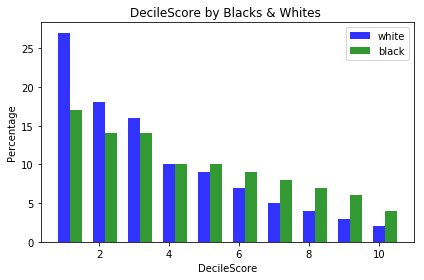

In [26]:
# Comparing White & Black defendants on the  'DecileScore'
grp_plot_compare(white, black, 'DecileScore','Ethnic_Code_Text', len(df), 100, \
                 'DecileScore by Blacks & Whites ', \
                 'white','black')

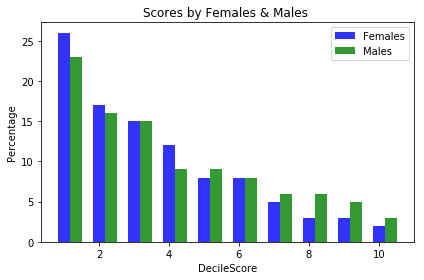

In [27]:
# Comparing Male & Female defendants on the  'DecileScore'
grp_plot_compare(female, male, 'DecileScore','Sex_Code_Text', len(df), 100, \
                 'Scores by Females & Males ', \
                 'Females','Males')


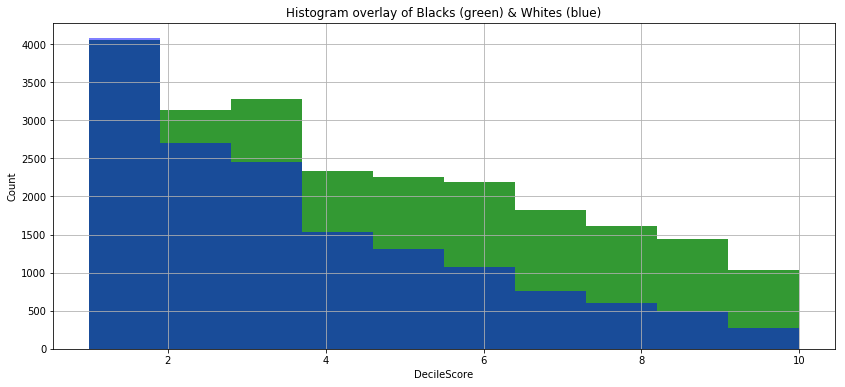

In [28]:
####################################################################################
# Histogram overlay
fig, ax = plt.subplots()
black['DecileScore'].hist(bins=10, figsize=[14,6],color='g',alpha=.8 )
white['DecileScore'].hist(bins=10, figsize=[14,6],color='b',alpha=.5 )
plt.title('Histogram overlay of Blacks (green) & Whites (blue)')
plt.legend()
plt.xlabel('DecileScore')
plt.ylabel('Count')
plt.show()
plt.clf()

# Running ML models

In [29]:
# Define prepare_data_for_ml_model_1:
def prepare_data_for_ml_model_1(dfx, target_loc):
    # Create new DataFrame of selected columns
     
    """
    Columns
    0 - 4  : 'Person_ID','AssessmentID','Case_ID','Agency_Text', 'LastName',
    5 - 9  : 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text','DateOfBirth',
    10 - 14: 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason','Language', 'LegalStatus',
    15 - 19: 'CustodyStatus', 'MaritalStatus','Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
    20 - 24: 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
    25 - 28: 'AssessmentType', 'IsCompleted', 'IsDeleted','Age'
    """
    """
    race, age, criminal history, future recidivism, charge degree, gender and age.
    """
    # slice for subset data features and targets
    df_new = dfx.iloc[:, [7,8,14,15,16,19,28]] #features
    y = dfx.iloc[:,target_loc] #target

    
    #  One-Hot encoder. It encodes the data into binary format
    le = preprocessing.LabelEncoder()

    Sex_Code_Text_cat = le.fit_transform(df_new.Sex_Code_Text)
    Ethnic_Code_Text_cat = le.fit_transform(df_new.Ethnic_Code_Text)
    LegalStatus_cat = le.fit_transform(df_new.LegalStatus)
    CustodyStatus_cat = le.fit_transform(df_new.CustodyStatus)
    MaritalStatus_cat = le.fit_transform(df_new.MaritalStatus)
    RecSupervisionLevelText_cat = le.fit_transform(df_new.RecSupervisionLevelText) 
 
    df_new['Sex_Code_Text_cat'] = Sex_Code_Text_cat
    df_new['Ethnic_Code_Text_cat'] = Ethnic_Code_Text_cat
    df_new['LegalStatus_cat'] = LegalStatus_cat
    df_new['CustodyStatus_cat'] = CustodyStatus_cat
    df_new['MaritalStatus_cat'] = MaritalStatus_cat
    df_new['RecSupervisionLevelText_cat'] = RecSupervisionLevelText_cat



    #drop the old categorical columns from dataframe

    dummy_fields = ['Sex_Code_Text',
                  'Ethnic_Code_Text',  'LegalStatus', 'CustodyStatus',
                  'MaritalStatus','RecSupervisionLevelText' ]
    

    df_new = df_new.drop(dummy_fields, axis = 1)
    print('columns:',df_new.columns)

    # Standardizing
    #X_std = StandardScaler().fit_transform(X_rev)


    # Split data train and test, first import library
    X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.2)
    print('Length for X_train:', len(X_train), ' X_test:',len(X_test), ' y_train:',len(y_train) ,' y_test:',len(y_test))

    return X_train, X_test, y_train, y_test


In [30]:
# Define ml_model_1:
# takes in model Instantiate model (model)
# fits, predicts, and evaluates (prints results)
def ml_model_1(model, modelnm, dfnm, X_train, X_test, y_train, y_test, target):
    print('Running ', modelnm, ' model for :', dfnm, ' using target: ', target)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Evaluate
    print(modelnm,' score: ',model.score(X_test, y_test))
    print(' ')
    print('first 10 predicted values: ',y_pred[0:10])
    print('first 10 values of target: ')
    print(y_test.head(10))
    print(' ')

    print('mean of predicted of values: ',np.mean(y_pred), ' STD of predicted of values : ', np.std(y_pred) )
    print('describe of target')
    print(y_test.describe())

    return y_pred

In [ ]:
# MLPRegressor

In [31]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(alpha=0.001, hidden_layer_sizes = (10,), max_iter = 50000, 
                 activation = 'logistic', verbose = 'True', learning_rate = 'adaptive')

In [32]:
# MLPRegressor - RiskViolence dataset target RawScore (22)
# Preparing the data
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskViolence,22)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 12808  X_test: 3202  y_train: 12808  y_test: 3202


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
# Predicting and getting score
ml_model_1(clf, 'MLPRegressor', 'RiskViolence', X_train, X_test, y_train, y_test, 'RawScore')

Running  MLPRegressor  model for : RiskViolence  using target:  RawScore
Iteration 1, loss = 3.38473830
Iteration 2, loss = 1.91331564
Iteration 3, loss = 0.70592092
Iteration 4, loss = 0.42301826
Iteration 5, loss = 0.34769019
Iteration 6, loss = 0.31499223
Iteration 7, loss = 0.30014298
Iteration 8, loss = 0.27427751
Iteration 9, loss = 0.24851338
Iteration 10, loss = 0.23077670
Iteration 11, loss = 0.21755039
Iteration 12, loss = 0.20256543
Iteration 13, loss = 0.18837050
Iteration 14, loss = 0.17842074
Iteration 15, loss = 0.17221949
Iteration 16, loss = 0.16788929
Iteration 17, loss = 0.16499476
Iteration 18, loss = 0.16272286
Iteration 19, loss = 0.16095215
Iteration 20, loss = 0.15970266
Iteration 21, loss = 0.15845635
Iteration 22, loss = 0.15748293
Iteration 23, loss = 0.15658164
Iteration 24, loss = 0.15604925
Iteration 25, loss = 0.15509973
Iteration 26, loss = 0.15454831
Iteration 27, loss = 0.15403340
Iteration 28, loss = 0.15353148
Iteration 29, loss = 0.15327126
Iteratio

array([-1.95118069, -3.06207915, -1.399232  , ..., -2.74960106,
       -2.77638613, -2.46603081])

In [ ]:
# MLPRegressor  score:  0.7974618120468234

In [34]:
# MLPRegressor - RiskRecidivism dataset target RawScore (22)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,22)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
# Predicting and getting score
ml_model_1(clf, 'MLPRegressor', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'RawScore')

Running  MLPRegressor  model for : RiskRecidivism  using target:  RawScore
Iteration 1, loss = 0.27373409
Iteration 2, loss = 0.24869807
Iteration 3, loss = 0.21224413
Iteration 4, loss = 0.19475817
Iteration 5, loss = 0.18851556
Iteration 6, loss = 0.18556436
Iteration 7, loss = 0.18367241
Iteration 8, loss = 0.18242032
Iteration 9, loss = 0.18111654
Iteration 10, loss = 0.18039743
Iteration 11, loss = 0.17972123
Iteration 12, loss = 0.17892674
Iteration 13, loss = 0.17820237
Iteration 14, loss = 0.17731568
Iteration 15, loss = 0.17649056
Iteration 16, loss = 0.17573058
Iteration 17, loss = 0.17477251
Iteration 18, loss = 0.17367931
Iteration 19, loss = 0.17255673
Iteration 20, loss = 0.17069238
Iteration 21, loss = 0.16646077
Iteration 22, loss = 0.16138607
Iteration 23, loss = 0.15595698
Iteration 24, loss = 0.14900248
Iteration 25, loss = 0.14283990
Iteration 26, loss = 0.13655233
Iteration 27, loss = 0.13079293
Iteration 28, loss = 0.12481162
Iteration 29, loss = 0.11897979
Iterat

array([-0.97476077,  0.43814779, -0.91055668, ..., -1.03100571,
       -0.25597387, -1.01683345])

In [ ]:
# MLPRegressor  score:  0.7778680496718294

In [36]:
#  Running again but using DecileScore as the target
# MLPRegressor - RiskRecidivism dataset target DecileScore (23)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,23)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
# Predicting and getting score
y_pred_MLPR = ml_model_1(clf, 'MLPRegressor', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'DecileScore')

Running  MLPRegressor  model for : RiskRecidivism  using target:  DecileScore
Iteration 1, loss = 16.90451270
Iteration 2, loss = 12.12520511
Iteration 3, loss = 8.89732783
Iteration 4, loss = 7.79945122
Iteration 5, loss = 7.02020527
Iteration 6, loss = 6.39127812
Iteration 7, loss = 5.87511932
Iteration 8, loss = 5.45103258
Iteration 9, loss = 5.10457033
Iteration 10, loss = 4.82433363
Iteration 11, loss = 4.59865969
Iteration 12, loss = 4.42109845
Iteration 13, loss = 4.28188842
Iteration 14, loss = 4.17446095
Iteration 15, loss = 4.09331884
Iteration 16, loss = 4.03260054
Iteration 17, loss = 3.98812106
Iteration 18, loss = 3.95573412
Iteration 19, loss = 3.93294511
Iteration 20, loss = 3.91712207
Iteration 21, loss = 3.90613362
Iteration 22, loss = 3.89891720
Iteration 23, loss = 3.89396762
Iteration 24, loss = 3.89078714
Iteration 25, loss = 3.88874744
Iteration 26, loss = 3.88747570
Iteration 27, loss = 3.88669484
Iteration 28, loss = 3.88614296
Iteration 29, loss = 3.88576486
I

In [ ]:
# MLPRegressor  score:  0.8300451961620092

# Test Bias by substituting 'Caucasian' to 'African-American' in the RiskRecidivism dataset

In [38]:
# getting subset data from RiskRecidivism dataset
whiteRR = RiskRecidivism.loc[RiskRecidivism['Ethnic_Code_Text'] == 'Caucasian']
blackRR = RiskRecidivism.loc[RiskRecidivism['Ethnic_Code_Text'] == 'Caucasian']

In [39]:
# substituting 'Caucasian' to 'African-American' in the dataset
blackRR.loc[blackRR['Ethnic_Code_Text'] != 'African-American', 'Ethnic_Code_Text'] = 'African-American'

C:\Users\rivas\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
# Validating data
pd.value_counts(whiteRR['Ethnic_Code_Text'])

Caucasian    5092
Name: Ethnic_Code_Text, dtype: int64

In [41]:
pd.value_counts(blackRR['Ethnic_Code_Text'])

African-American    5092
Name: Ethnic_Code_Text, dtype: int64

In [ ]:
# Using the DecileScore for the target

In [42]:
# Prepare data for model for whiteRR dataset 
Xwht_train, Xwht_test, ywht_train, ywht_test =  prepare_data_for_ml_model_1(whiteRR,23)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 4073  X_test: 1019  y_train: 4073  y_test: 1019


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
# Prepare data for model for blackRR dataset 
Xblk_train, Xblk_test, yblk_train, yblk_test = prepare_data_for_ml_model_1(blackRR,23)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 4073  X_test: 1019  y_train: 4073  y_test: 1019


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
# Using MLPRegressor using the WhiteRR training data
clf.fit(Xwht_train, ywht_train)

Iteration 1, loss = 13.70782848
Iteration 2, loss = 13.01468627
Iteration 3, loss = 12.05988298
Iteration 4, loss = 10.54569115
Iteration 5, loss = 8.85629037
Iteration 6, loss = 7.75220948
Iteration 7, loss = 7.16908433
Iteration 8, loss = 6.78768430
Iteration 9, loss = 6.48747554
Iteration 10, loss = 6.22821711
Iteration 11, loss = 5.99369520
Iteration 12, loss = 5.77871260
Iteration 13, loss = 5.58076191
Iteration 14, loss = 5.39737378
Iteration 15, loss = 5.22947621
Iteration 16, loss = 5.07187750
Iteration 17, loss = 4.92543576
Iteration 18, loss = 4.79157513
Iteration 19, loss = 4.66633517
Iteration 20, loss = 4.54975592
Iteration 21, loss = 4.44304165
Iteration 22, loss = 4.34496699
Iteration 23, loss = 4.25380891
Iteration 24, loss = 4.16941265
Iteration 25, loss = 4.09271250
Iteration 26, loss = 4.02082441
Iteration 27, loss = 3.95590284
Iteration 28, loss = 3.89653645
Iteration 29, loss = 3.84106411
Iteration 30, loss = 3.79123691
Iteration 31, loss = 3.74524293
Iteration 32,

Iteration 265, loss = 1.59637785
Iteration 266, loss = 1.59568559
Iteration 267, loss = 1.59221102
Iteration 268, loss = 1.59104099
Iteration 269, loss = 1.59018319
Iteration 270, loss = 1.58914627
Iteration 271, loss = 1.58810055
Iteration 272, loss = 1.58780994
Iteration 273, loss = 1.58664786
Iteration 274, loss = 1.58633819
Iteration 275, loss = 1.58486723
Iteration 276, loss = 1.58413326
Iteration 277, loss = 1.58265002
Iteration 278, loss = 1.58213725
Iteration 279, loss = 1.58114622
Iteration 280, loss = 1.58055843
Iteration 281, loss = 1.58008669
Iteration 282, loss = 1.57926952
Iteration 283, loss = 1.57833863
Iteration 284, loss = 1.57813777
Iteration 285, loss = 1.57705654
Iteration 286, loss = 1.57586216
Iteration 287, loss = 1.57570877
Iteration 288, loss = 1.57476512
Iteration 289, loss = 1.57453861
Iteration 290, loss = 1.57410766
Iteration 291, loss = 1.57346540
Iteration 292, loss = 1.57243051
Iteration 293, loss = 1.57373586
Iteration 294, loss = 1.57081914
Iteration 

Iteration 531, loss = 0.74561856
Iteration 532, loss = 0.74656830
Iteration 533, loss = 0.74222340
Iteration 534, loss = 0.74057056
Iteration 535, loss = 0.74149677
Iteration 536, loss = 0.73858326
Iteration 537, loss = 0.73879467
Iteration 538, loss = 0.73839838
Iteration 539, loss = 0.73494092
Iteration 540, loss = 0.73467712
Iteration 541, loss = 0.73567784
Iteration 542, loss = 0.73312925
Iteration 543, loss = 0.73218299
Iteration 544, loss = 0.73100024
Iteration 545, loss = 0.72861433
Iteration 546, loss = 0.72775497
Iteration 547, loss = 0.72697903
Iteration 548, loss = 0.72703636
Iteration 549, loss = 0.72528057
Iteration 550, loss = 0.72450307
Iteration 551, loss = 0.72378681
Iteration 552, loss = 0.72240115
Iteration 553, loss = 0.72139427
Iteration 554, loss = 0.72086711
Iteration 555, loss = 0.72053392
Iteration 556, loss = 0.72046969
Iteration 557, loss = 0.71771978
Iteration 558, loss = 0.71976357
Iteration 559, loss = 0.71686108
Iteration 560, loss = 0.71729720
Iteration 

MLPRegressor(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=50000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose='True', warm_start=False)

In [45]:
# Predict for whiteRR dataset 
ywht_pred = clf.predict(Xwht_test)

In [49]:
# Predict for blackRR dataset 
yblk_pred = clf.predict(Xblk_test)

In [47]:
# rounding predicted results and converting into integers
rndwht = (np.round(ywht_pred,0)).astype(int)

In [50]:
rndblk = (np.round(yblk_pred,0)).astype(int)

In [51]:
# comparing results
collections.Counter(ywht_test) # base test target

Counter({1: 161,
         2: 171,
         3: 144,
         4: 138,
         5: 111,
         6: 80,
         7: 71,
         8: 59,
         9: 52,
         10: 32})

In [52]:
collections.Counter(rndwht)    # white predict

Counter({2: 226, 3: 416, 4: 43, 5: 19, 6: 122, 7: 37, 8: 94, 9: 62})

In [53]:
collections.Counter(rndblk)    # black predict

Counter({1: 1, 2: 238, 3: 407, 4: 39, 5: 15, 6: 112, 7: 38, 8: 94, 9: 75})